# Сборный проект

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

###### Описание данных:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


### 1. Импортируем нужные нам библиотеки и прочитаем предоставленные данные. 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
display(data.head())
data.info()
data.duplicated().sum()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


0

In [4]:
data.isna().mean()

Name               0.000120
Platform           0.000000
Year_of_Release    0.016093
Genre              0.000120
NA_sales           0.000000
EU_sales           0.000000
JP_sales           0.000000
Other_sales        0.000000
Critic_Score       0.513192
User_Score         0.400897
Rating             0.404786
dtype: float64

В предоставленных данных дубликатов нет. Есть пропуски в столбцах Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating. Пропуски в столбцах с оценками и рейтингом не предполагают каких либо замен, а с остальными пропусками поработаем в следующем шаге. Так же нужно заменить в некоторых столбцах типы данных.

### 2. Подготовка данных

---

Приведем названия стобцов к нижнему регистру, переименуем столбцы для удобства.

In [5]:
data.columns = data.columns.str.lower()
data = data.rename(columns={'year_of_release':'release'})

---

В столбцах name, release, genre присутсвует крайне малое количество пропусков - 1%, которые мы можем исключить из исследования.

In [6]:
data = data.dropna(subset=['name', 'release', 'genre']).reset_index(drop=True)

Заменим тип данных в столбце release с float на int.

In [7]:
data['release'] = data['release'].astype(int)

В столбце user_score есть аббревиатура 'tbd'. Так обозначается оценка пользователей, которая не была определена. Произведем замену этого обозначения на Nan, и заменим тип данных на float.

In [8]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [9]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan
data['user_score'] = data['user_score'].astype(float)

Добавим новый столбец с посчитанными суммарными продажами во всех регионах.


In [10]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

---

### 3. Исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы. Для этого сгруппируем наши данные по годам, и применим функцию agg для подсчета количества игр выпущенных в эти годы. Построим график.

In [11]:
group_release = data.groupby('release').agg({'name':'count'}).reset_index()

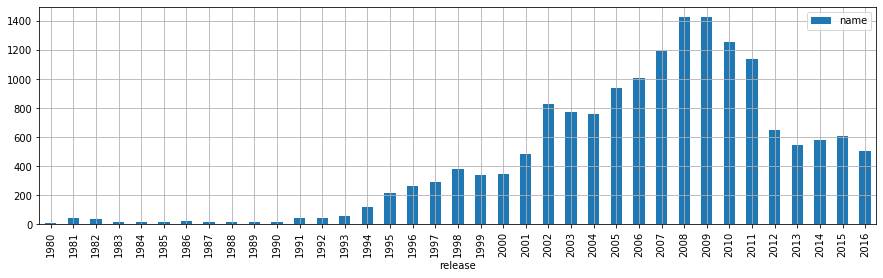

In [12]:
group_release.plot.bar(x='release', y='name', figsize=(15, 4), grid=True)
plt.show()

На графике видно, как начиная с 2001 года, количество выпускаемых игр резко возрасло. Данные раньше этого года для нас не важны.

---

Посмотрим, как менялись продажи по платформам. Для этого выберем 10 платформ с наибольшими суммарными продажами и построим распределение по годам. 

In [13]:
platform_max = data.groupby('platform').agg({'total_sales':'sum'}).sort_values(by='total_sales', ascending=False).head(10)

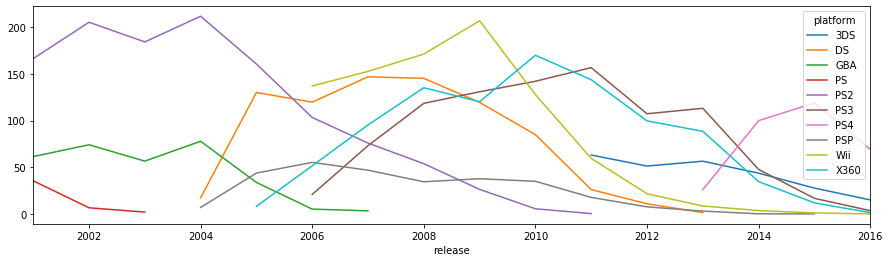

In [14]:
fig, ax = plt.subplots(figsize=(15,4))
pd.pivot_table(data.query('platform.isin(@platform_max.index) and release > 2000'),
              index ='release',
              columns = 'platform',
              values='total_sales',
              aggfunc='sum').plot (ax=ax)
plt.show()



----
Добавим в исходную таблицу столбец показывающий жизненный цикл по каждой платформе. Найдем медианное значение по новому столбцу.



In [15]:
data['lifetime']  = data.groupby('platform')['release'].transform(lambda s: s.max() - s.min())

In [16]:
data['lifetime'].median()

10.0

Значение медианы жизненного цикла составило 10 лет. Но новые консоли появляются не в момент исчезновения старых, рассмотрим жизненный цикл на примере одного производителя Sony. От самой ранней даты релиза игр младшего поколения консолей вычтем самую раннюю дату старшего поколения.

In [17]:
display(data.query('platform == "PS4"')['release'].min() - data.query('platform == "PS3"')['release'].min())
display(data.query('platform == "PS3"')['release'].min() - data.query('platform == "PS2"')['release'].min())
display(data.query('platform == "PS2"')['release'].min() - data.query('platform == "PS"')['release'].min())

7

6

6

Можно сделать вывод что после релиза нового поколения консолей, игры на старое поколение выпускают ещё 3-4 года.

----

В результате предыдущего исследования, был определен актуальный период. Так как нам надо спрогнозировать на 2017 год, возмем за актуальный период данные после выхода последнего поколения платформ.

In [18]:
current_data = data.query('release > 2012').reset_index(drop=True)

Выясним, какие платформы лидируют по продажам, посмотрим на график и выберем несколько потенциально прибыльных платформ.

In [19]:
cr = current_data.groupby('platform').agg({'total_sales':'sum'})

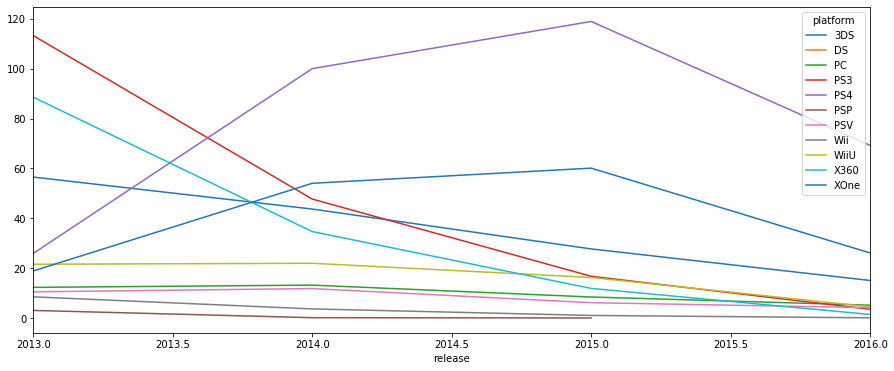

In [20]:
fig, ax = plt.subplots(figsize=(15,6))
pd.pivot_table(data.query('platform.isin(@cr.index) and release > 2012'),
              index ='release',
              columns = 'platform',
              values='total_sales',
              aggfunc='sum').plot (ax=ax)
plt.show()

К 2016 году, продажи игр падают на всех платформах, но для некоторых из них это является следствием неактуальности платформы, а для некоторых причина не известна. В этом случае потенциально прибыльными платформами можно назвать те, на которых год первого релиза не превышает актуальные период. К этим платформам в потенцильно прибыльные следует добавить PC, так как эта платформа не имеет жизненного цикла и является всегда актуальной.

Потенциально прибыльные:
- PS4
- XOne
- PC

---

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. 

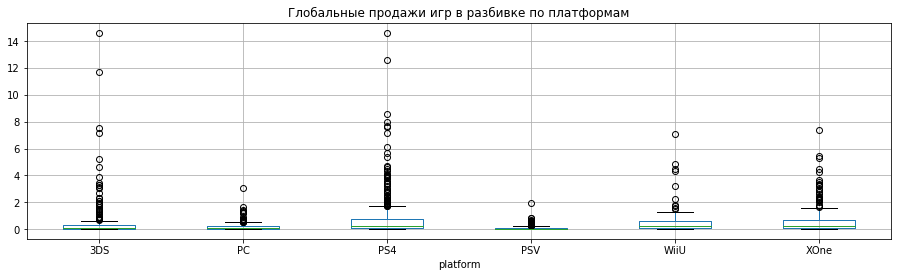

In [21]:
platform_name = ['3DS','PS4','XOne','WiiU','PSV','PC']
fig, ax = plt.subplots(figsize=(15, 4))
current_data.query('platform in @platform_name').boxplot('total_sales', by='platform', ax=ax)
plt.suptitle(None)
plt.title('Глобальные продажи игр в разбивке по платформам')
plt.show()

Построим еще один boxplot с ограничением по оси Y

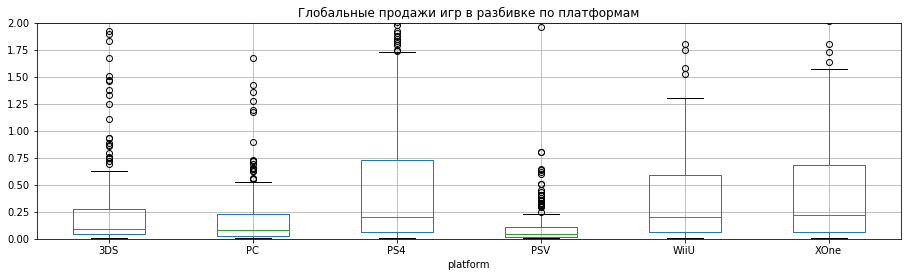

In [22]:
platform_name = ['3DS','PS4','XOne','WiiU','PSV','PC']
fig, ax = plt.subplots(figsize=(15, 4))
current_data.query('platform in @platform_name').boxplot('total_sales', by='platform', ax=ax)
plt.suptitle(None)
plt.title('Глобальные продажи игр в разбивке по платформам')
plt.ylim(0,2)
plt.show()

Больше зарабатывают на продажах игр на домашних приставках. Меньше всего зарабатывают на платформах портативных консолей и PC. Но даже на них выходят очень популярные игры, которые делают кассу.

---
Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков на примере PS4. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

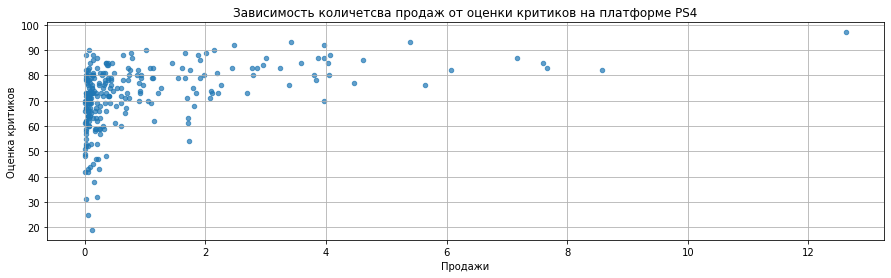

Коэффициент корреляции Пирсона: 0.406567902061781


In [23]:
(current_data
         .query('platform == "PS4"')
         .plot(x='total_sales', y='critic_score', kind='scatter', grid=True, figsize=(15,4), alpha=0.7, title='Зависимость количетсва продаж от оценки критиков на платформе PS4')
)
plt.ylabel('Оценка критиков')
plt.xlabel('Продажи')
plt.show()
print('Коэффициент корреляции Пирсона:', current_data.query('platform == "PS4"')['total_sales'].corr(current_data.query('platform == "PS4"')['critic_score']))

Существует небольшая зависимоть, чем выше оценка критиков, тем больше продажи.

---

Посмотрим тоже самое для оценки пользователей.

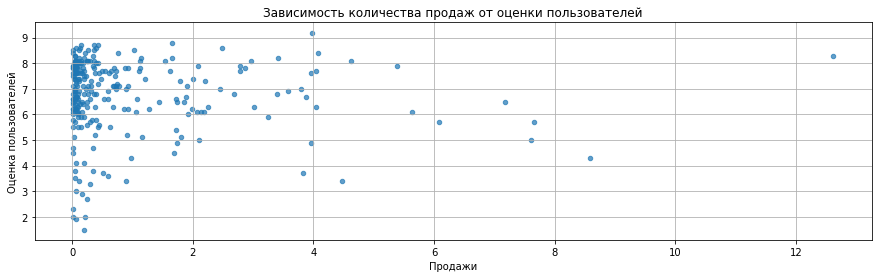

Коэффициент корреляции Пирсона: -0.031957110204556424


In [24]:
(current_data
         .query('platform == "PS4"')
         .plot(x='total_sales', y='user_score', kind='scatter', grid=True, figsize=(15,4), alpha=0.7, title='Зависимость количества продаж от оценки пользователей')
)
plt.ylabel('Оценка пользователей')
plt.xlabel('Продажи')
plt.show()
print('Коэффициент корреляции Пирсона:', current_data.query('platform == "PS4"')['total_sales'].corr(current_data.query('platform == "PS4"')['user_score']))

Зависимость очень слабая, оценка пользователей не влияет на продажи.

---

Рассмотрим влияние оценок критиков на продажи на других платформах.

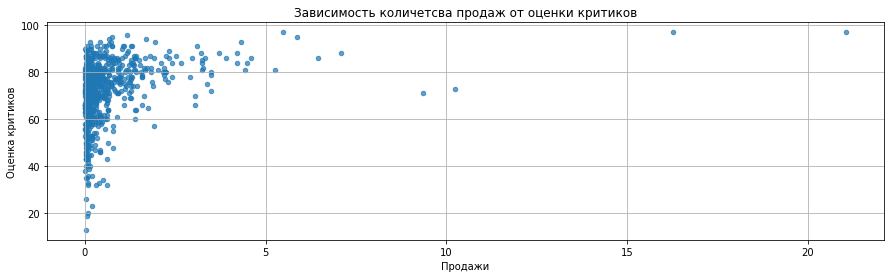

Коэффициент корреляции Пирсона: 0.2812510848217569


In [25]:
(current_data
         .query('platform != "PS4"')
         .plot(x='total_sales', y='critic_score', kind='scatter', grid=True, figsize=(15,4), alpha=0.7, title='Зависимость количетсва продаж от оценки критиков')
)
plt.ylabel('Оценка критиков')
plt.xlabel('Продажи')
plt.show()
print('Коэффициент корреляции Пирсона:', current_data.query('platform != "PS4"')['total_sales'].corr(current_data.query('platform != "PS4"')['critic_score']))

На других платформах зависимоть стала меньше, но все же прослеживается. Оценка критиков все еще оказывает влияние на продажи.

---

Рассмотрим влияние оценок пользователей на продажи на других платформах.

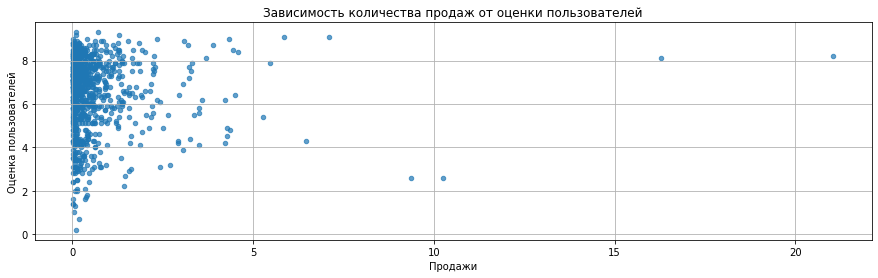

Коэффициент корреляции Пирсона: -0.0011216242093378549


In [26]:
(current_data
         .query('platform != "PS4"')
         .plot(x='total_sales', y='user_score', kind='scatter', grid=True, figsize=(15,4), alpha=0.7, title='Зависимость количества продаж от оценки пользователей')
)
plt.ylabel('Оценка пользователей')
plt.xlabel('Продажи')
plt.show()
print('Коэффициент корреляции Пирсона:', current_data.query('platform != "PS4"')['total_sales'].corr(current_data.query('platform != "PS4"')['user_score']))

Коэфициент Пирсона для других платформ все ещё мал, что бы делать выводы о зависимости продаж от оценки пользователей.

---

Посмотрим на распределение игр по жанрам.

In [27]:
current_data.groupby('genre').agg({'total_sales':'sum'}).sort_values(by='total_sales', ascending=False)

,total_sales
genre,
Action,321.87
Shooter,232.98
Sports,150.65
Role-Playing,145.89
Misc,62.82
Platform,42.63
Racing,39.89
Fighting,35.31
Adventure,23.64


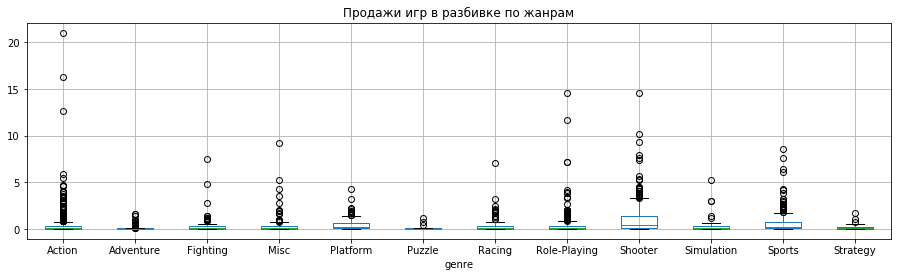

In [28]:
fig, ax = plt.subplots(figsize=(15, 4))
current_data.boxplot('total_sales', by='genre', ax=ax)
plt.suptitle(None)
plt.title('Продажи игр в разбивке по жанрам')
plt.show()

Построим еще один boxplot с ограничением по оси Y

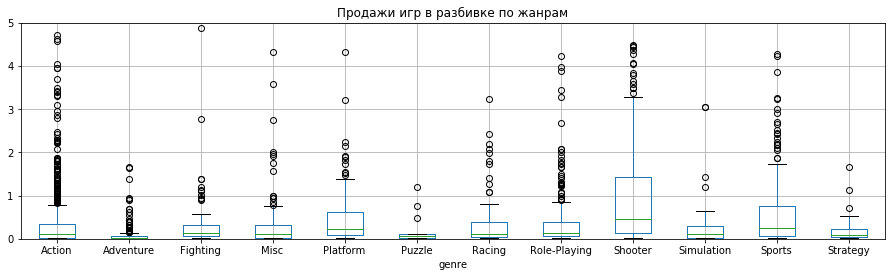

In [29]:
fig, ax = plt.subplots(figsize=(15, 4))
current_data.boxplot('total_sales', by='genre', ax=ax)
plt.suptitle(None)
plt.title('Продажи игр в разбивке по жанрам')
plt.ylim(0,5)
plt.show()

Самым прибыльным жанром по общей сумме продаж является Action, но посмотрев на график boxplot видно, что такие результаты мы получили благодаря выбросам. В действительности же самым стабильным в плане прибыли жанром является Shooter. Жанр Puzzle с самыми низкими продажами. Жанры с высокими продажами направлены на более широкую аудиторию, и более сложную структуру игр. Игры жанров с низкими продажами более примитивны и узко направленные.

 - Наиболее актуальными для нас жанрами являются Shooter, Action, Sports и Role-Playing

---


###  4. Портрет пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):
 - Самые популярные платформы (топ-5)
 - Самые популярные жанры (топ-5)

In [30]:
region_list = ['na_sales','eu_sales','jp_sales']
for region in region_list:
    print('Топ-5 платформ по региону {}'.format(region))
    region_df = current_data.query(f'{region} > 0').groupby('platform').agg({region:'count'}).sort_values(by=region, ascending=False)
    region_df['%'] = (region_df[region] / region_df[region].sum()).map('{:,.1%}'.format)
    display(region_df.head())
    print('Топ-5 жанров по региону {}'.format(region))
    genre_df = current_data.groupby('genre').agg({region:'sum'}).sort_values(by=region, ascending=False)
    genre_df['%'] = (genre_df[region] / genre_df[region].sum()).map('{:,.1%}'.format)
    display(genre_df.head())
    

Топ-5 платформ по региону na_sales


,na_sales,%
platform,,
PS4,294,22.5%
XOne,227,17.3%
PS3,211,16.1%
X360,170,13.0%
3DS,119,9.1%


Топ-5 жанров по региону na_sales


,na_sales,%
genre,,
Action,126.05,28.8%
Shooter,109.74,25.1%
Sports,65.27,14.9%
Role-Playing,46.40,10.6%
Misc,27.49,6.3%


Топ-5 платформ по региону eu_sales


,eu_sales,%
platform,,
PS4,290,20.4%
XOne,218,15.3%
PS3,212,14.9%
PC,187,13.2%
X360,169,11.9%


Топ-5 жанров по региону eu_sales


,eu_sales,%
genre,,
Action,118.13,30.1%
Shooter,87.86,22.4%
Sports,60.52,15.4%
Role-Playing,36.97,9.4%
Racing,20.19,5.1%


Топ-5 платформ по региону jp_sales


,jp_sales,%
platform,,
PSV,316,26.6%
PS3,236,19.9%
3DS,235,19.8%
PS4,223,18.8%
PSP,66,5.6%


Топ-5 жанров по региону jp_sales


,jp_sales,%
genre,,
Role-Playing,51.04,36.3%
Action,40.49,28.8%
Misc,9.20,6.5%
Fighting,7.65,5.4%
Shooter,6.61,4.7%


Вывод: 
 - Для региона **NA** в топе платформ находятся как консоли нового поколения с долей в **39,8%**, так и консоли прошлого поколения, на которые приходится **29,1%** выпускаемых игр. Самым прибыльным жанром является *Action*, что соответсвует результатам предыдущего исследования. Продажи игр с этим жанром составляют **28,8%**. Жанр *Shooter* который как мы выяснили является наиболее потенцильно прибыльным занимает **25,1%**
 - Для региона **EU** характерно следуещее, в топе те же две консоли нового поколения с долей **35,7%** и две консоли прошлого поколения, доля выпускаемых на них игр составляет **26,8%** и к ним в топе прибавилась платформа *PC* с существенной долей в **13,2%**. Распределение по жанрам идентично распределению в регионе **NA**.
 - Для региона **JP** заметна популярность портативных игровых консолей, которые в топе платформ представлены в количестве 3 штук, доля игр для них составляет **52%**. Самым популярным жанром в отличии от других регионов является *Role-Playing*, доля продаж таких игр составляет **36,3%**, а самый кассовый жанр по всей выборке *Action*, в этом регионе находится на втором месте по популярности с долей продаж **28,8%**.
  
 
 
 
---

Рассмотрим, влияет ли рейтинг **ESRB** на продажи в отдельном регионе. В стобце с рейтингом присутсвуют пропуски, заменим их на обозначение Unknown, что бы не потерять эти строки.

In [31]:
current_data = current_data.fillna({'rating':'Unknown'})
esrb = current_data.groupby(['rating']).agg({'na_sales':'sum', 'eu_sales':'sum', 'jp_sales':'sum'})
esrb['na_share'] = (esrb['na_sales'] / esrb['na_sales'].sum()).map('{:,.1%}'.format)
esrb['eu_share'] = (esrb['eu_sales'] / esrb['eu_sales'].sum()).map('{:,.1%}'.format)
esrb['jp_share'] = (esrb['jp_sales'] / esrb['jp_sales'].sum()).map('{:,.1%}'.format)
esrb

,na_sales,eu_sales,jp_sales,na_share,eu_share,jp_share
rating,,,,,,
E,79.05,83.36,15.14,18.1%,21.3%,10.8%
E10+,54.24,42.69,5.89,12.4%,10.9%,4.2%
M,165.21,145.32,14.11,37.7%,37.0%,10.0%
T,49.79,41.95,20.59,11.4%,10.7%,14.6%
Unknown,89.42,78.91,85.05,20.4%,20.1%,60.4%


- Для региона **NA** самым распространенным по продажам рейтингом является **M**, категория 17+. Доля продаж составляет **37,7%**. Следующим по популярности жанром является **E**, для всех старше 6+ с долей **18,1%**. Есть игры для которых рейтинг не определен и их доля составляет **20,4%**
- Для региона **EU** ситуация очень похожа с регионом **NA**. Самыми продаваемыми играми являются игры с рейтингом **M** доля продаж **37%**, игры с рейтингом **E** на втором месте по популярности с долей продаж **21,3%**. Тут тоже присутсвуют игры с не известным рейтингом, их доля **20,1%**
- Для региона **JP** доля игр для которых рейтинг не известен, составляет аж **60,4%**, связано это вероятнее всего с тем, что рейтинг *ESRB* в первую очередь относится к Канаде и США, поэтому игры выпущенные в Японии и продаваемые только в Японии не попадают в эту систему рейтингов. По имеющимся данным можно сказать что самым продаваемым рейтингом является **T**(13+) с долей **14,6%**, следующим по популярности является рейтинг **E** доля продаж игр с таким рейтингом составляет **10,8%**



---

### 5. Проверка гипотез

##### Проверим следующие гипотезы:
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
2. Средние пользовательские рейтинги жанров Action и Sports разные.

Для того что бы проверить первую гипотезу, примем за нулевую гипотезу то, что средние наших выборок равны. Альтернативной гипотезой в данном случае будет являться то, что средние пользовательские рейтинги платформ Xbox One и PC различаются. Так как количество наблюдений >30, можем воспользоваться критерием t - Стьюдента.

In [32]:
alpha = .05
results = st.ttest_ind(current_data.query('platform == "XOne" and user_score > 0')['user_score'], current_data.query('platform == "PC" and user_score > 0')['user_score'], equal_var = False)

print('Дисперсия Xbox One', np.var(current_data.query('platform == "XOne"')['user_score'], ddof=1))
print('Дисперсия PC', np.var(current_data.query('platform == "PC"')['user_score'], ddof=1))
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Дисперсия Xbox One 1.9069968429360695
Дисперсия PC 3.035892752408881
p-значение: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


Средние пользовательские рейтинги платформ Xbox One и PC равны.

---

Для того что бы проверить вторую гипотезу, примем за нулевую гипотезу то, что средние наших выборок равны. Альтернативной гипотезой в данном случае будет являться то, что средние пользовательские рейтинги жанров Action и Sport различаются. Так как количество наблюдений >30, можем воспользоваться критерием t - Стьюдента.

In [33]:
alpha = .05
results = st.ttest_ind(current_data.query('genre == "Action" and user_score > 0')['user_score'], current_data.query('genre == "Sports" and user_score > 0')['user_score'], equal_var = False)

print('Дисперсия жанра Action', np.var(current_data.query('genre == "Action"')['user_score'], ddof=1))
print('Дисперсия жанра Sports', np.var(current_data.query('genre == "Sports"')['user_score'], ddof=1))
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Дисперсия жанра Action 1.7693609042482705
Дисперсия жанра Sports 3.180612814465409
p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


Полученное значение p-value слишком мало, можно сделать вывод о значимом различии между средними пользовательскими рейтингами жанров Action и Sports.

### 6. Общий вывод

    Продажи игр переживают не лучшие времена, но это не значит что игры перестали выпускать. Наша задача была в том, что бы выявить закономерности успешности игры, что бы сделать ставку на потенциально популярный продукт. 

    Выбор потенцильно популярного продукта и рекламные кампании в нашем случае должны различаться по регионам, так как они имеют свою специфику:
 - Регионы Европы и Северной Америки можно объедить, они имеют схожие черты в популярности платформ и идентично попопулярные жанры игр. Популярны платформы по большей части домашних консолей старого/нового поколения. А так же имеют схожее распределение по рейтингу ESRB продаваемых игр.
 - Японию стоит рассматривать отдельно, на этом рынке популярны иные жанры и платформы в отличии от других регионов. А именно Role-Playing в качестве самого популярного жанра. В качестве самых популярных платформ выступают портативные консоли. Так же нужно ознакомится с рейтингом присваиваемым играм в Японии и соотнести его с рейтингом ESRB, так как для 60,4% игр проданных в Японии рейтинг ESRB не указан вовсе.
 
Подводя итог, нам следует присмотреться к новым играм в жанрах Action, Shooter, Sport, Role-playing на новом поколении консолей(PS4, XOne) и PC, а так же активно следить за выходом игр на новых портативных консолях, а именно Nintendo Switch, анонс которой был в октябре 2016 года.